# 후판 scale(산화철)불량 분석

[목적] : 후판의 가열로, 압연공정에서의 scale불량의 원인을 찾고 개선을 위한 최적의 조건 도출

[분석 절차]
1. 데이터 준비 및 현황 파악 
  - 데이터 현황, 품질 확인
  - 이상치 제거, 변환 등
  - (필요시) 데이터 분리
2. 탐색적 분석:
  - 그래프 분석
  - 통계 검정 등
3. 영향인자 도출 
  - 탐색적 분석
  - 통계(로지스틱 회귀분석)
  - ML 기법(Decision Tree, Random Forest, 다양한 Boosting 모델)
4. 도출된 영향인자 해석 및 선정
5. 불량예측 모델링 및 개선안 도출

## 데이터 이해

* 데이터 양: 2023/01/03~01/09(7일), 1000 plates* 1000 Plates

* 변수 설명

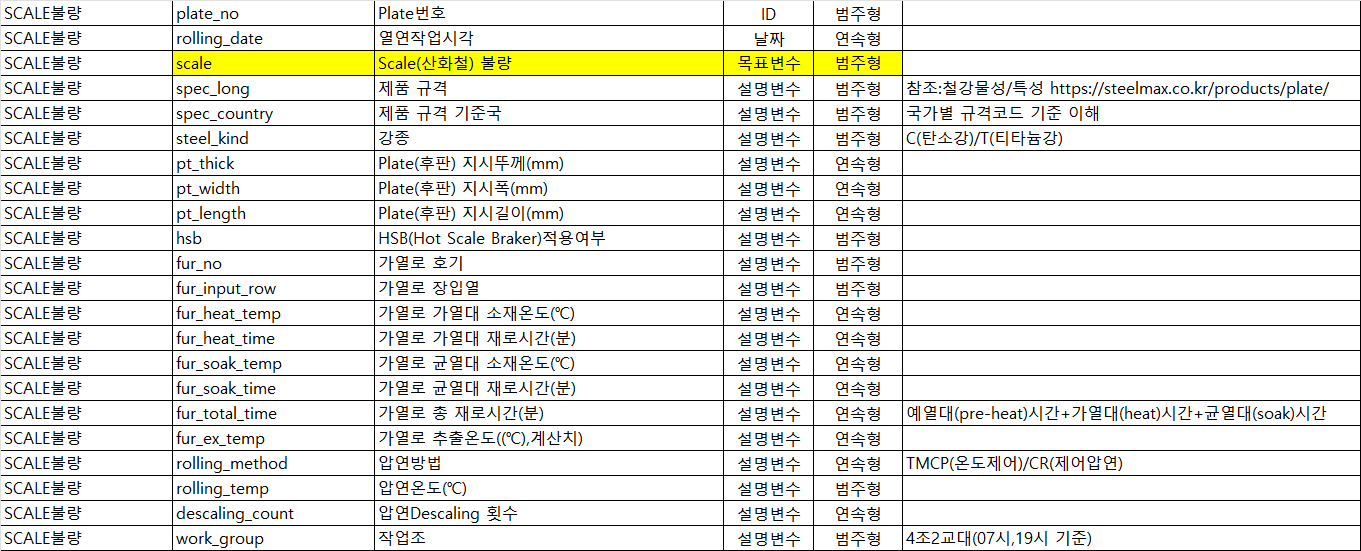

# 0.분석 준비

## ..패키지 불러오기

In [1]:
# 데이터 구성:Series, DataFrame
import pandas as pd 
import numpy as np

# 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

# Tree 결과 확인
from sklearn.tree import export_graphviz
import graphviz

# 로지스틱 회귀
import statsmodels.api as sm
from statsmodels.api import Logit

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

## ..옵션 지정

In [2]:
# pandas 소수점 3자리
pd.options.display.precision = 3

# 그래프 한글 폰트(맑은 고딕)
matplotlib.rc("font", family="Malgun Gothic")
# 그래프 (-) 기호 표시
matplotlib.rc("axes", unicode_minus = False)

# Tree 생성경로 지정
import os
# PATH 설정: graphviz를 설치 했다면, 설치 된 경로를 설정. 기본 경로는 아래 예제 참고(linux에서 설치된 경로 확인 및 변경 필요)
os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"

## 사용자 정의 함수

In [3]:
# 목표변수와 연속형 설명변수 관계 확인(히스토그램)
def fun_plot_hist(data, var):
    plt.title(var)
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
    
# ====================    
    
# 목표변수와 범주형 설명변수 관계 확인(교차표)
def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["scale"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["scale"], columns = data[var], normalize = "columns").round(3))    

# 1.데이터 준비 및 현황 파악

## ..데이터 준비

In [4]:
# df_raw = pd.read_csv("D:/WORK/DATA/scale1000_final.csv", encoding="cp949")
df_raw = pd.read_csv("D:/WORK/DATA/scale불량.csv",encoding="cp949")

print("shape: ", df_raw.shape)
df_raw.head()

shape:  (1000, 22)


,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


## ..데이터 현황/품질 파악

In [5]:
# 결측치 확인
df_raw.isnull().sum()

# ...결측 없음

plate_no           0
rolling_date       0
scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

In [6]:
# 기초 통계량 확인 
# print(df_raw.describe())
df_raw.describe(include='all')

# ...이상치 확인:rolling_temp(0) ..

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
count,1000,1000,1000,1000,1000,1000,1000.000,1000.000,1000.000,1000,...,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000,1000.000,1000.000,1000
unique,1000,1000,2,66,7,2,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,4
top,PLT_1001,03JAN2023:07:07:53,양품,JS-SM490YB,영국,C,NaN,NaN,NaN,적용,...,NaN,NaN,NaN,NaN,NaN,NaN,CR(제어압연),NaN,NaN,2조
freq,1,1,690,84,256,755,NaN,NaN,NaN,953,...,NaN,NaN,NaN,NaN,NaN,NaN,840,NaN,NaN,292
mean,NaN,NaN,NaN,NaN,NaN,NaN,26.782,2831.900,36788.200,NaN,...,1157.245,85.972,1150.928,71.720,238.589,1150.928,NaN,934.637,8.557,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,18.138,494.081,13912.387,NaN,...,21.245,26.346,17.344,20.602,38.195,17.344,NaN,96.598,1.604,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,12.000,1800.000,7900.000,NaN,...,1103.000,55.000,1113.000,35.000,165.000,1113.000,NaN,0.000,5.000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,15.000,2500.000,26650.000,NaN,...,1140.000,66.000,1135.750,57.750,210.000,1135.750,NaN,893.750,8.000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,19.000,2800.000,40400.000,NaN,...,1159.000,75.000,1156.000,66.000,230.000,1156.000,NaN,948.000,9.000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,34.000,3100.000,49100.000,NaN,...,1173.000,102.250,1164.000,81.000,263.000,1164.000,NaN,991.000,10.000,NaN


array([[<AxesSubplot:title={'center':'pt_thick'}>,
        <AxesSubplot:title={'center':'pt_width'}>,
        <AxesSubplot:title={'center':'pt_length'}>],
       [<AxesSubplot:title={'center':'fur_heat_temp'}>,
        <AxesSubplot:title={'center':'fur_heat_time'}>,
        <AxesSubplot:title={'center':'fur_soak_temp'}>],
       [<AxesSubplot:title={'center':'fur_soak_time'}>,
        <AxesSubplot:title={'center':'fur_total_time'}>,
        <AxesSubplot:title={'center':'fur_ex_temp'}>],
       [<AxesSubplot:title={'center':'rolling_temp'}>,
        <AxesSubplot:title={'center':'descaling_count'}>, <AxesSubplot:>]],
      dtype=object)

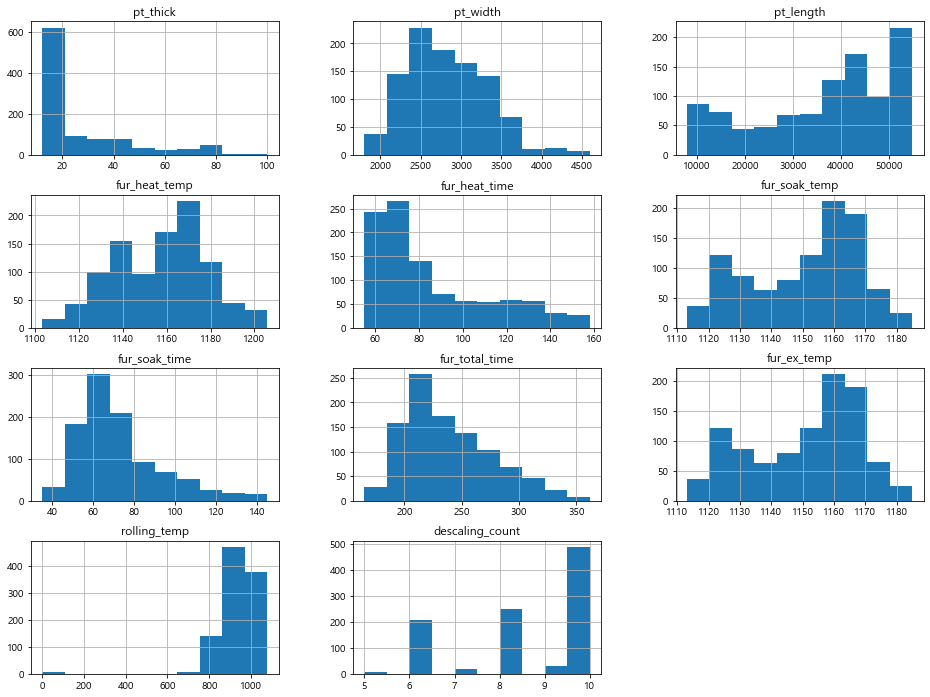

In [7]:
# 연속형 변수 분포
df_raw.hist(figsize=(16,12))

# ...좌/우로 치우침. 이상치 확인:rolling_temp(0)

<AxesSubplot:>

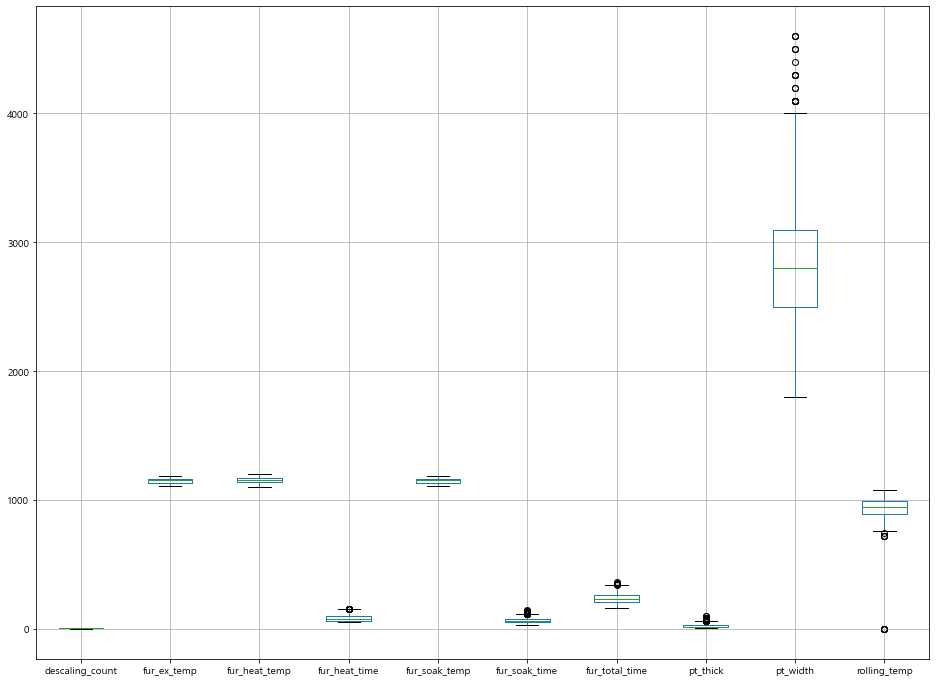

In [8]:
# Boxplot 확인
# df_raw.boxplot(figsize=(16,12))

# 특정컬럼 선택
# df_raw[['fur_heat_temp', 'fur_soak_temp', 'fur_ex_temp', 'rolling_temp']].boxplot(figsize=(16,12))
# 특정컬럼 제외
df_raw[df_raw.columns.difference(['pt_length'])].boxplot(figsize=(16,12))
# df_raw[df_raw.columns.difference(['pt_length', 'pt_width', 'descaling_count'])].boxplot(figsize=(16,12))

In [9]:
# 범주형 변수명 리스트
cols_class = df_raw.select_dtypes(include='object').columns
cols_class

Index(['plate_no', 'rolling_date', 'scale', 'spec_long', 'spec_country',
       'steel_kind', 'hsb', 'fur_no', 'fur_input_row', 'rolling_method',
       'work_group'],
      dtype='object')

In [10]:
print('Scale불량... \n',df_raw['scale'].value_counts(),'\n')
print('규격... \n',df_raw['spec_long'].value_counts(),'\n')
print('규격국... \n',df_raw['spec_country'].value_counts(),'\n')
print('강종... \n',df_raw['steel_kind'].value_counts(),'\n')

print('HSB적용... \n',df_raw['hsb'].value_counts(),'\n')
print('가열로 호기... \n',df_raw['fur_no'].value_counts(),'\n')
print('가열로 장입렬... \n',df_raw['fur_input_row'].value_counts(),'\n')
print('열연방법... \n',df_raw['rolling_method'].value_counts(),'\n')
print('작업조... \n',df_raw['work_group'].value_counts(),'\n')

Scale불량... 
 양품    690
불량    310
Name: scale, dtype: int64 

규격... 
 JS-SM490YB     84
LR-A           81
LR-AH32        52
AB/A           51
NV-A           48
               ..
LR-AH36         1
BV-AH36-TM      1
A131-DH36TM     1
KR-B            1
KS-HSB600       1
Name: spec_long, Length: 66, dtype: int64 

규격국... 
 영국     256
일본     187
미국     159
프랑스    143
한국     132
독일      87
공통      36
Name: spec_country, dtype: int64 

강종... 
 C    755
T    245
Name: steel_kind, dtype: int64 

HSB적용... 
 적용     953
미적용     47
Name: hsb, dtype: int64 

가열로 호기... 
 3호기    342
1호기    333
2호기    325
Name: fur_no, dtype: int64 

가열로 장입렬... 
 1열    508
2열    492
Name: fur_input_row, dtype: int64 

열연방법... 
 CR(제어압연)      840
TMCP(온도제어)    160
Name: rolling_method, dtype: int64 

작업조... 
 2조    292
1조    280
3조    218
4조    210
Name: work_group, dtype: int64 



## ..데이터 품질 강화 및 분리

* 이상치 처리
    - 압연온도:500도 미만 제거
       
* 데이터 분리
    - 강종:C(탄소강) 우선 분석 ..불량률 높음
    
* 기타...

### 이상치 처리 및 데이터 분리

<AxesSubplot:>

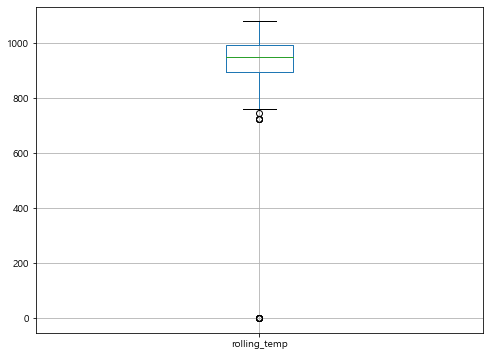

In [11]:
# 특정변수 선택
df_raw[['rolling_temp']].boxplot(figsize=(8,6))

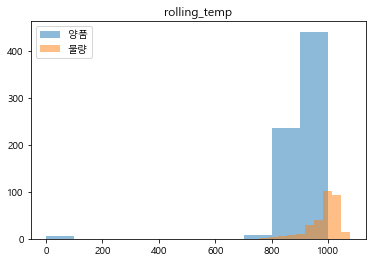

In [12]:
fun_plot_hist(df_raw, 'rolling_temp') 
# 압연온도 < 500 제거

### @@이상치 제거!!!

(994, 22)


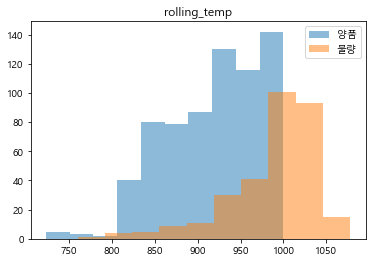

In [13]:
# 압연온도 < 500 제거
df_raw_wo = df_raw[df_raw['rolling_temp'] >= 500]
df_raw_wo.reset_index(drop=True, inplace=True)
print(df_raw_wo.shape)
# print(df_raw_wo.info())

fun_plot_hist(df_raw_wo, 'rolling_temp')

In [14]:
# 이상치 추가 확인되면 적절한 처리 ....
df_raw_wo.head(10)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조
5,PLT_1006,03JAN2023:08:01:55,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1143,127,1128,57,255,1128,TMCP(온도제어),874,8,1조
6,PLT_1007,03JAN2023:08:14:02,양품,BV-EH36-TM,프랑스,T,38,3100,16700,적용,...,1138,126,1130,50,278,1130,TMCP(온도제어),878,8,1조
7,PLT_1008,03JAN2023:08:24:12,양품,BV-EH36-TM,프랑스,T,38,3100,16700,적용,...,1139,126,1131,52,272,1131,TMCP(온도제어),870,8,1조
8,PLT_1009,03JAN2023:08:38:23,양품,BV-EH36-TM,프랑스,T,38,3100,16700,적용,...,1127,126,1122,52,241,1122,TMCP(온도제어),873,8,1조
9,PLT_1010,03JAN2023:08:45:58,불량,AB/EH36-TM,미국,T,38,3100,16200,적용,...,1135,119,1124,73,290,1124,TMCP(온도제어),881,7,1조


# 2.탐색적 분석,EDA
* 그래프 분석
* 통계적 검정

## ..Scale불량 vs. 연속형 변수 관계 확인(히스토그램)

##### plate 두께

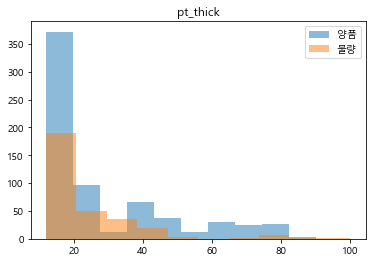

In [15]:
fun_plot_hist(df_raw_wo, "pt_thick")

##### plate 폭

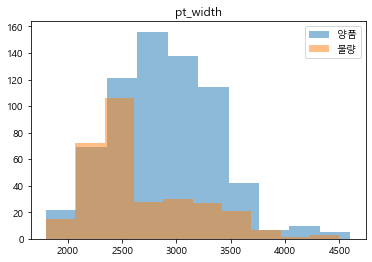

In [16]:
fun_plot_hist(df_raw_wo, "pt_width")

##### plate 길이

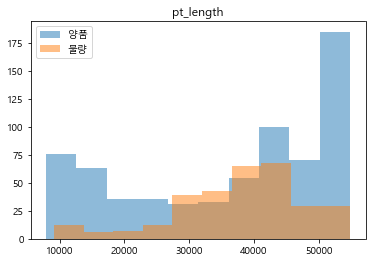

In [17]:
fun_plot_hist(df_raw_wo, "pt_length")

##### 가열로 가열대 온도

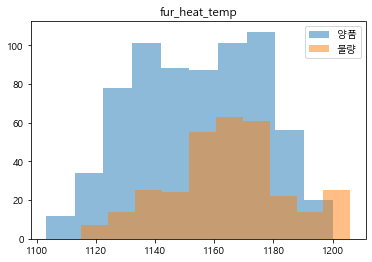

In [18]:
fun_plot_hist(df_raw_wo, "fur_heat_temp")

##### 가열로 균열대 시간

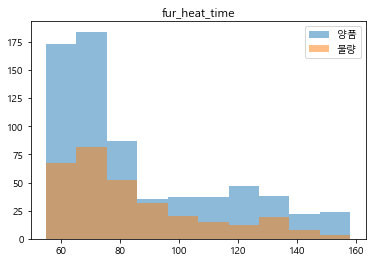

In [19]:
fun_plot_hist(df_raw_wo, "fur_heat_time")

##### 가열로 균열대 온도

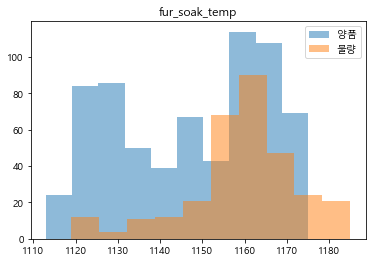

In [20]:
fun_plot_hist(df_raw_wo, "fur_soak_temp")

##### 가열로 균열대 시간

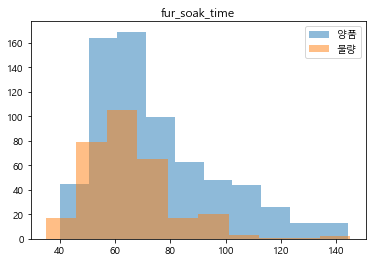

In [21]:
fun_plot_hist(df_raw_wo, "fur_soak_time")

##### 가열로 시간

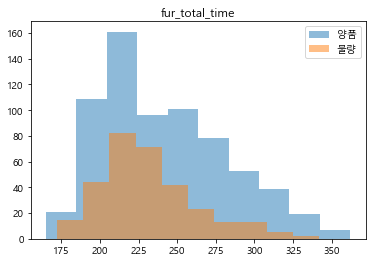

In [22]:
fun_plot_hist(df_raw_wo, "fur_total_time")

##### 가열로 출측온도

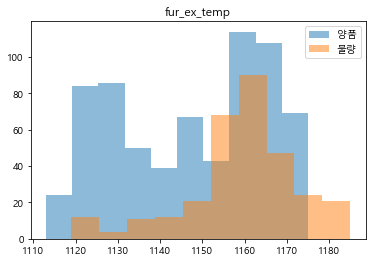

In [23]:
fun_plot_hist(df_raw_wo, "fur_ex_temp")

##### 압연 온도

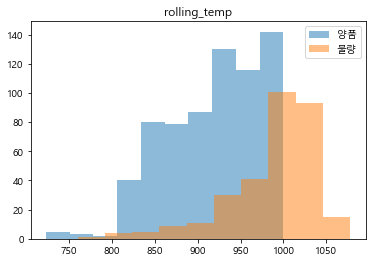

In [24]:
fun_plot_hist(df_raw_wo, "rolling_temp")
# 이상치 처리 필요!!


##### 압연 중 Descaling 횟수

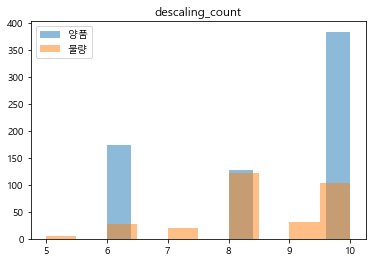

In [25]:
fun_plot_hist(df_raw_wo, "descaling_count")
# 선형 관계 없음

## ..Scale불량 vs. 범주형 변수 관계 확인(교차표)

##### 규격/규격국

In [26]:
fun_print_crosstab(df_raw_wo, "spec_long")
print()
fun_print_crosstab(df_raw_wo, "spec_country")

spec_long  A131-DH36TM  A283-C  A516-60  A709-36  AB/A  AB/AH32  AB/B  \
scale                                                                   
불량                   1       5        2        0    13        8     3   
양품                   0       1        1        1    38       23     6   

spec_long  AB/EH32-TM  AB/EH36-TM  API-2W-50T  ...  NV-A32-TM  NV-A36-TM  \
scale                                          ...                         
불량                  0           2           0  ...          1          0   
양품                  2          30           2  ...          2          2   

spec_long  NV-B  NV-D32-TM  NV-D36-TM  NV-E32-TM  NV-E36-TM  PILAC-BT33  \
scale                                                                     
불량            2          0          1          0          0           2   
양품            1          3          4          2          5          36   

spec_long  SA283-C  V42JBN3  
scale                        
불량              10        1  
양품         

##### 강종

In [27]:
fun_print_crosstab(df_raw_wo, "steel_kind")
# 강종별 불량 편차 확인 --> C(탄소강) 우선 분석

steel_kind    C    T
scale               
불량          290   20
양품          463  221

steel_kind      C      T
scale                   
불량          0.385  0.083
양품          0.615  0.917


##### HSB 적용

In [28]:
fun_print_crosstab(df_raw_wo, "hsb")

hsb    미적용   적용
scale          
불량      47  263
양품       0  684

hsb    미적용     적용
scale            
불량     1.0  0.278
양품     0.0  0.722


##### 가열로 호기/장입렬

In [29]:
fun_print_crosstab(df_raw_wo, "fur_no")
print()
fun_print_crosstab(df_raw_wo, "fur_input_row")

fur_no  1호기  2호기  3호기
scale                
불량      101   92  117
양품      231  232  221

fur_no    1호기    2호기    3호기
scale                      
불량      0.304  0.284  0.346
양품      0.696  0.716  0.654

fur_input_row   1열   2열
scale                  
불량             165  145
양품             340  344

fur_input_row     1열     2열
scale                      
불량             0.327  0.297
양품             0.673  0.703


##### 작업조

In [30]:
fun_print_crosstab(df_raw_wo, "work_group")

work_group   1조   2조   3조   4조
scale                         
불량          109   85   66   50
양품          170  205  149  160

work_group     1조     2조     3조     4조
scale                                 
불량          0.391  0.293  0.307  0.238
양품          0.609  0.707  0.693  0.762


##### 압연Descaling 횟수 (연속형 또는 범주형)

In [31]:
fun_print_crosstab(df_raw_wo, "descaling_count")

descaling_count  5    6   7    8   9    10
scale                                     
불량                6   28  20  122  31  103
양품                0  174   0  127   0  383

descaling_count   5      6    7     8    9      10
scale                                             
불량               1.0  0.139  1.0  0.49  1.0  0.212
양품               0.0  0.861  0.0  0.51  0.0  0.788


## ..분석 데이터 선택 및 변환, 분할
      
* 데이터 분리
    - 강종:C(탄소강) 우선 분석 ..불량률 높음

* 목표변수 변환:불량/양품 -> 1/0 (로지스틱 회귀분석 적용 목적)

* 로지스틱 회귀용: df_anal_lr, 기계학습용: df_anal

* 데이터 분할:train vs. test : 7:3

* 기타...

### @@분석 대상 관측치/변수 선택

* 관측치 선택
    - 강종 = "C"-탄소강
    - 기타 ...
    
* 변수 선택
    - plate_no, rolling_date, spec_long 제외
    - 기타 ...

In [32]:
# 관측치 선택
# 불량 높고 생산량 많은 탄소강 우선 분석
df_anal = df_raw_wo[df_raw_wo['steel_kind']=='C']
# 복수 조건 적용시
# df_anal = df_raw_wo[(df_raw_wo['steel_kind']=='C') & (df_raw_wo['hsb']=='적용') ]
df_anal.reset_index(drop=True, inplace=True)

# 변수 선택
df_anal.drop(["plate_no", "rolling_date", "spec_long"], axis = 1, inplace = True)

print(df_anal.info(), '\n')  # scale            753 non-null    object
print('Scale불량... \n',df_anal['scale'].value_counts(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            753 non-null    object
 1   spec_country     753 non-null    object
 2   steel_kind       753 non-null    object
 3   pt_thick         753 non-null    int64 
 4   pt_width         753 non-null    int64 
 5   pt_length        753 non-null    int64 
 6   hsb              753 non-null    object
 7   fur_no           753 non-null    object
 8   fur_input_row    753 non-null    object
 9   fur_heat_temp    753 non-null    int64 
 10  fur_heat_time    753 non-null    int64 
 11  fur_soak_temp    753 non-null    int64 
 12  fur_soak_time    753 non-null    int64 
 13  fur_total_time   753 non-null    int64 
 14  fur_ex_temp      753 non-null    int64 
 15  rolling_method   753 non-null    object
 16  rolling_temp     753 non-null    int64 
 17  descaling_count  753 non-null    in

C:\Users\greeninsight\AppData\Local\Temp\ipykernel_1848\3654929318.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anal.drop(["plate_no", "rolling_date", "spec_long"], axis = 1, inplace = True)


# 3.영향인자 도출

* 탐색적 분석
* 통계(로지스틱 회귀분석)
* ML 기법(Decision Tree, Random Forest, 다양한 Boosting 모델)

## 로지스틱 회귀분석

### @@ 로지스틱 분석용 데이터 준비

* 로지스틱 회귀분석:목표변수 변환(문자형 -> 숫자형) 및 분할: df_anal -> df_anal_lr -> df_train/df_test


In [33]:
# 목표변수 변환
df_anal_lr = df_anal.copy() # 필요시
df_anal_lr['scale'] = np.where(df_anal_lr['scale']== '양품', 0, 1)

print(df_anal_lr.info(), '\n')  # scale            753 non-null    int32 
print('1/0 변환 Scale불량... \n',df_anal_lr['scale'].value_counts(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            753 non-null    int32 
 1   spec_country     753 non-null    object
 2   steel_kind       753 non-null    object
 3   pt_thick         753 non-null    int64 
 4   pt_width         753 non-null    int64 
 5   pt_length        753 non-null    int64 
 6   hsb              753 non-null    object
 7   fur_no           753 non-null    object
 8   fur_input_row    753 non-null    object
 9   fur_heat_temp    753 non-null    int64 
 10  fur_heat_time    753 non-null    int64 
 11  fur_soak_temp    753 non-null    int64 
 12  fur_soak_time    753 non-null    int64 
 13  fur_total_time   753 non-null    int64 
 14  fur_ex_temp      753 non-null    int64 
 15  rolling_method   753 non-null    object
 16  rolling_temp     753 non-null    int64 
 17  descaling_count  753 non-null    in

In [34]:
# 데이터 분할
df_train, df_test = train_test_split(df_anal_lr, test_size = 0.3)

print("Shape(Train): ", df_train.shape)
print("Shape(Test): ", df_test.shape)

display(df_train.head(3))

Shape(Train):  (527, 19)
Shape(Test):  (226, 19)


,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
234,1,프랑스,C,19,3300,42900,적용,2호기,1열,1157,63,1161,62,197,1161,CR(제어압연),975,9,1조
479,1,한국,C,23,2800,46400,적용,3호기,1열,1172,140,1162,51,293,1162,CR(제어압연),1001,8,3조
383,0,영국,C,13,3500,53300,적용,2호기,1열,1118,62,1129,107,274,1129,CR(제어압연),840,10,3조


#### 예측 및 모델 성능평가

In [35]:
"""목표변수: scale
범주형:spec_long spec_country steel_kind hsb fur_no fur_input_row rolling_method work_group
연속형:pt_thick pt_width pt_length fur_heat_temp fur_heat_time fur_soak_temp fur_soak_time
    fur_total_time fur_ex_temp rolling_temp descaling_count
    
분석 불필요 변수:spec_long(규격-종류 많음), steel_kind(탄소강 선택)
"""
# 모델 구성: 적절한 변수 추가/삭제 반복 작업

model_lr = sm.Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + 
                C(spec_country) + C(hsb) + C(fur_no) + C(fur_input_row)+ C(rolling_method) + C(work_group) +
                fur_heat_temp + fur_heat_time + fur_soak_temp + fur_soak_time + fur_total_time +
                fur_ex_temp + rolling_temp + 1""" ,
                                  df_train)

# 적합
result_lr = model_lr.fit()
# 결과 출력
print(result_lr.summary())

         Current function value: 0.336850
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                           21
Date:                Mon, 09 Jan 2023   Pseudo R-squ.:                  0.5033
Time:                        10:09:00   Log-Likelihood:                -177.52
converged:                      False   LL-Null:                       -357.39
Covariance Type:            nonrobust   LLR p-value:                 1.878e-63
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -117.2437    558.994     -0.210      0.834   -1212.852     978.364
C(spec_country)[T.미국]      0.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# 예측 
y_pred_train = result_lr.predict(df_train)
y_pred_test = result_lr.predict(df_test)

# 확률값 -> 0/1 로 변환
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = (y_pred_test > 0.5).astype(int)

# 모델 성능 평가
print("Train 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_train["scale"], y_pred_train)),"\n")
print("Accuracy... {:.3f}\n".format(accuracy_score(df_train["scale"], y_pred_train)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_train["scale"], y_pred_train, digits=3))

print("Test 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_test["scale"], y_pred_test)),"\n")
print("Accuracy... {:.3f}\n".format(accuracy_score(df_test["scale"], y_pred_test)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_test["scale"], y_pred_test, digits=3))

Train 모델...
Confusion matrix... 
[[273  36]
 [ 36 182]] 

Accuracy... 0.863
 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

           0      0.883     0.883     0.883       309
           1      0.835     0.835     0.835       218

    accuracy                          0.863       527
   macro avg      0.859     0.859     0.859       527
weighted avg      0.863     0.863     0.863       527

Test 모델...
Confusion matrix... 
[[131  23]
 [ 15  57]] 

Accuracy... 0.832
 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

           0      0.897     0.851     0.873       154
           1      0.713     0.792     0.750        72

    accuracy                          0.832       226
   macro avg      0.805     0.821     0.812       226
weighted avg      0.838     0.832     0.834       226



#### Scale 적용 후 변수 중요도 확인--> 영향인자 선정 활용

In [37]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_char = df_anal_lr.select_dtypes(include = "object")
df_num = df_anal_lr.select_dtypes(exclude = "object")

# Scaling: 목표변수도 정수 -> 실수형 변환 ==> 재변환(정수화, (1/0)) 필요
scaler = StandardScaler()
np_num_scaled = scaler.fit_transform(df_num)
df_num_scaled = pd.DataFrame(np_num_scaled, columns=df_num.columns)

# df_num_scaled.info()

# 문자 데이터 + 숫자 데이터
df_anal_scaled = pd.concat([df_num_scaled, df_char], axis = 1)

print(df_anal_scaled.info(),"\n")
df_anal_scaled.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            753 non-null    float64
 1   pt_thick         753 non-null    float64
 2   pt_width         753 non-null    float64
 3   pt_length        753 non-null    float64
 4   fur_heat_temp    753 non-null    float64
 5   fur_heat_time    753 non-null    float64
 6   fur_soak_temp    753 non-null    float64
 7   fur_soak_time    753 non-null    float64
 8   fur_total_time   753 non-null    float64
 9   fur_ex_temp      753 non-null    float64
 10  rolling_temp     753 non-null    float64
 11  descaling_count  753 non-null    float64
 12  spec_country     753 non-null    object 
 13  steel_kind       753 non-null    object 
 14  hsb              753 non-null    object 
 15  fur_no           753 non-null    object 
 16  fur_input_row    753 non-null    object 
 17  rolling_method  

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group
0,-0.791,0.205,1.444,-0.433,-1.820,-0.262,-2.798,3.280,1.901,-2.798,-0.638,-1.14,프랑스,C,적용,3호기,1열,CR(제어압연),2조
1,-0.791,0.205,1.444,-0.410,-1.235,-0.572,-2.283,2.397,0.153,-2.283,-1.116,-1.14,프랑스,C,적용,3호기,2열,CR(제어압연),2조
2,-0.791,-0.193,1.034,-0.398,-1.767,-0.456,-2.454,2.902,0.294,-2.454,-0.618,0.70,미국,C,적용,2호기,2열,CR(제어압연),2조


In [38]:
# scale 적용으로 실수형으로 변환된 목표변수 정수화 (1/0)
df_anal_scaled["scale"] = np.where(df_anal_scaled["scale"]> 0, 1, 0)
df_anal_scaled.head(3)

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group
0,0,0.205,1.444,-0.433,-1.820,-0.262,-2.798,3.280,1.901,-2.798,-0.638,-1.14,프랑스,C,적용,3호기,1열,CR(제어압연),2조
1,0,0.205,1.444,-0.410,-1.235,-0.572,-2.283,2.397,0.153,-2.283,-1.116,-1.14,프랑스,C,적용,3호기,2열,CR(제어압연),2조
2,0,-0.193,1.034,-0.398,-1.767,-0.456,-2.454,2.902,0.294,-2.454,-0.618,0.70,미국,C,적용,2호기,2열,CR(제어압연),2조


In [39]:
# 데이터 분할
df_train_scaled, df_test_scaled = train_test_split(df_anal_scaled, test_size = 0.3)

print("Shape(Train): ", df_train_scaled.shape)
print("Shape(Test): ", df_test_scaled.shape)
print()
print("정수 변환된 목표변수...", df_train_scaled["scale"].head(3))

Shape(Train):  (527, 19)
Shape(Test):  (226, 19)

정수 변환된 목표변수... 687    0
476    1
466    0
Name: scale, dtype: int32


In [40]:
# from_formula 함수를 이용하여 변수 역할 지정:hsb 제외
model_lr_scaled = sm.Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + 
                C(spec_country) +  C(fur_no) + C(fur_input_row)+ C(rolling_method) + C(work_group) +
                fur_heat_temp + fur_heat_time + fur_soak_temp + fur_soak_time + fur_total_time +
                fur_ex_temp + rolling_temp + 1""" ,
                                  df_train_scaled)

# 적합
result_lr_scaled = model_lr_scaled.fit()
# 결과 출력
print(result_lr_scaled.summary())

Optimization terminated successfully.
         Current function value: 0.444897
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      506
Method:                           MLE   Df Model:                           20
Date:                Mon, 09 Jan 2023   Pseudo R-squ.:                  0.3368
Time:                        10:09:00   Log-Likelihood:                -234.46
converged:                       True   LL-Null:                       -353.51
Covariance Type:            nonrobust   LLR p-value:                 2.837e-39
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2500      0.595     -0.420      0.674      -1.416      

<AxesSubplot:>

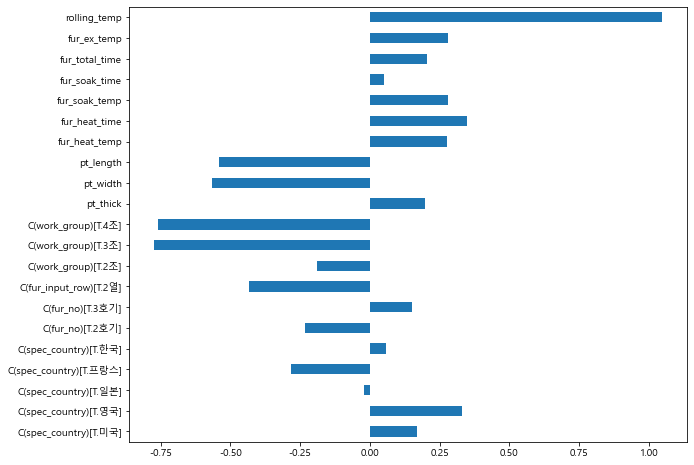

In [41]:
# Scaled 설명변수 중요도
df_lr_coef_scaled = pd.DataFrame({"Coef": result_lr_scaled.params.values[1:]}, index = model_lr_scaled.exog_names[1:])
df_lr_coef_scaled.plot.barh(y = "Coef", legend = False, figsize=(10,8))

### @@도출된 영향인자는 ...


### @@ 기계학습 분석용 데이터 준비(공통작업)

* 데이터 구분:목표 vs. 설명변수. df_anal_y (scale="불량", "양품")/df_anal_x
* 범주형 설명변수 dummy화: df_x_dummy
* 데이터 분할: df_x_dummy -> df_train_x/df_test_x, df_anal_y -> df_train_y/df_test_y

#### 목표/설명변수 구분

In [42]:
# 목표변수, 설명변수 구분
df_anal_y = df_anal["scale"]
df_anal_x = df_anal.drop(["scale"], axis = 1, inplace = False)

display("목표변수(양품/불량)...", df_anal_y.head(3))
display("설명변수...", df_anal_x.head(3))

'목표변수(양품/불량)...'

0    양품
1    양품
2    양품
Name: scale, dtype: object

'설명변수...'

,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,프랑스,C,20,3600,39300,적용,3호기,1열,1129,76,1126,118,297,1126,CR(제어압연),934,8,2조
1,프랑스,C,20,3600,39500,적용,3호기,2열,1140,68,1132,104,235,1132,CR(제어압연),911,8,2조
2,미국,C,17,3400,39600,적용,2호기,2열,1130,71,1130,112,240,1130,CR(제어압연),935,10,2조


#### 범주형 설명변수 더미 변환

In [43]:
# 범주형 설명변수 더미 변환
df_x_dummy = pd.get_dummies(df_anal_x)
print("Shape of dummy data:", df_x_dummy.shape)
df_x_dummy.head()

Shape of dummy data: (753, 30)


,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,...,fur_no_1호기,fur_no_2호기,fur_no_3호기,fur_input_row_1열,fur_input_row_2열,rolling_method_CR(제어압연),work_group_1조,work_group_2조,work_group_3조,work_group_4조
0,20,3600,39300,1129,76,1126,118,297,1126,934,...,0,0,1,1,0,1,0,1,0,0
1,20,3600,39500,1140,68,1132,104,235,1132,911,...,0,0,1,0,1,1,0,1,0,0
2,17,3400,39600,1130,71,1130,112,240,1130,935,...,0,1,0,0,1,1,0,1,0,0
3,17,3400,39600,1130,71,1130,112,287,1130,935,...,0,1,0,0,1,1,0,1,0,0
4,14,3300,51200,1140,80,1131,117,286,1131,915,...,1,0,0,1,0,1,0,1,0,0


#### 데이터 분할

In [45]:
# 데이터 분할:train/test 
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, df_anal_y, test_size = 0.3)

print("Shape(Train): ", df_train.shape)
print("Shape(Test): ", df_test.shape)

display(df_train_y.head(3))  # 불량/양품 유지

Shape(Train):  (527, 19)
Shape(Test):  (226, 19)


95     불량
121    불량
336    불량
Name: scale, dtype: object

### @@ 공통 (leaf 자료 수만 지정한)기본 옵션 모델을 이용하여 변수 중요도 확인--> 영향인자 탐색
* Leaf 최소 자료수는 train 자료 수의 2% 수준 지정

In [46]:
v_min_samples_leaf = int(len(df_train_x)*0.02)
print("Leaf 최소 자료수는 ..",v_min_samples_leaf) 

Leaf 최소 자료수는 .. 10


## 의사결정나무

In [47]:
dt_default = DecisionTreeClassifier(min_samples_leaf=v_min_samples_leaf)
dt_default.fit(df_train_x, df_train_y)

y_pred_train = dt_default.predict(df_train_x)
y_pred_test = dt_default.predict(df_test_x)

# 모델 성능 평가
print("Train 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_train_y, y_pred_train)),"\n")
print("Accuracy...  {:.3f}".format(dt_default.score(df_train_x, df_train_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_train_y, y_pred_train, digits=3))

print("Test 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_test_y, y_pred_test)),"\n")
print("Accuracy...  {:.3f}".format(dt_default.score(df_test_x, df_test_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_test_y, y_pred_test, digits=3))

Train 모델...
Confusion matrix... 
[[186   6]
 [  0 335]] 

Accuracy...  0.989 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     0.969     0.984       192
          양품      0.982     1.000     0.991       335

    accuracy                          0.989       527
   macro avg      0.991     0.984     0.988       527
weighted avg      0.989     0.989     0.989       527

Test 모델...
Confusion matrix... 
[[ 95   3]
 [  0 128]] 

Accuracy...  0.987 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     0.969     0.984        98
          양품      0.977     1.000     0.988       128

    accuracy                          0.987       226
   macro avg      0.989     0.985     0.986       226
weighted avg      0.987     0.987     0.987       226



### DT.변수 중요도...영향인자 선정

In [48]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
dt_importance = pd.DataFrame()
dt_importance["Feature"] = df_train_x.columns
dt_importance["Importance"] = dt_default.feature_importances_

# ds_feature_importance의 테이블을 중요도별로 정렬
dt_importance.sort_values("Importance", ascending=False, inplace = True)
dt_importance

,Feature,Importance
9,rolling_temp,0.574
5,fur_soak_temp,0.159
10,descaling_count,0.129
19,hsb_적용,0.128
7,fur_total_time,0.004
0,pt_thick,0.004
4,fur_heat_time,0.003
26,work_group_1조,0.000
18,hsb_미적용,0.000
27,work_group_2조,0.000


Text(0, 0.5, '설명변수')

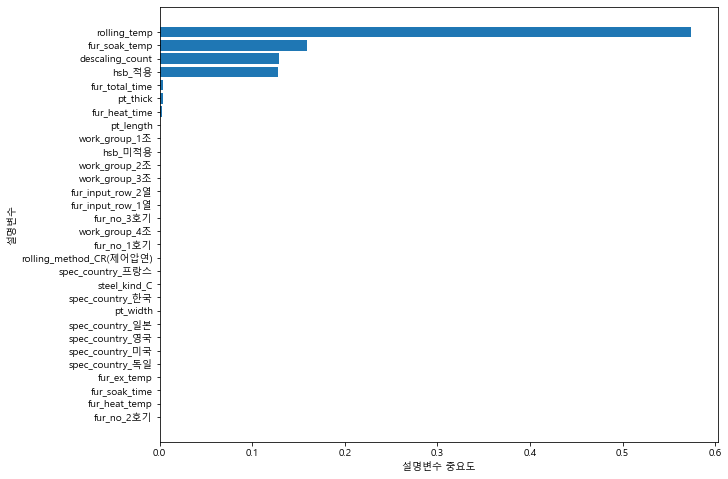

In [49]:
# 설명변수 중요도 그래프
plt.figure (figsize=(10, 8))

dt_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(dt_importance))
plt.barh(y = coordinates, width = dt_importance["Importance"])
plt.yticks(coordinates, dt_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### @@ DT.도출된 영향인자는 ...


## Random Forest

In [50]:
rf_default = RandomForestClassifier(min_samples_leaf=v_min_samples_leaf)
rf_default.fit(df_train_x, df_train_y)

y_pred_train = rf_default.predict(df_train_x)
y_pred_test = rf_default.predict(df_test_x)

# 모델 성능 평가
print("Train 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_train_y, y_pred_train)),"\n")
print("Accuracy...  {:.3f}".format(rf_default.score(df_train_x, df_train_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_train_y, y_pred_train, digits=3))

print("Test 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_test_y, y_pred_test)),"\n")
print("Accuracy...  {:.3f}".format(rf_default.score(df_test_x, df_test_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_test_y, y_pred_test, digits=3))

Train 모델...
Confusion matrix... 
[[158  34]
 [  0 335]] 

Accuracy...  0.935 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     0.823     0.903       192
          양품      0.908     1.000     0.952       335

    accuracy                          0.935       527
   macro avg      0.954     0.911     0.927       527
weighted avg      0.941     0.935     0.934       527

Test 모델...
Confusion matrix... 
[[ 74  24]
 [  0 128]] 

Accuracy...  0.894 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     0.755     0.860        98
          양품      0.842     1.000     0.914       128

    accuracy                          0.894       226
   macro avg      0.921     0.878     0.887       226
weighted avg      0.911     0.894     0.891       226



### RF.변수 중요도...영향인자 선정

In [51]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
rf_importance = pd.DataFrame()
rf_importance["Feature"] = df_train_x.columns
rf_importance["Importance"] = rf_default.feature_importances_

# ds_feature_importance의 테이블을 중요도별로 정렬
rf_importance.sort_values("Importance", ascending=False, inplace = True)
rf_importance

,Feature,Importance
9,rolling_temp,3.743e-01
1,pt_width,1.260e-01
0,pt_thick,1.037e-01
10,descaling_count,8.343e-02
5,fur_soak_temp,5.457e-02
2,pt_length,4.946e-02
8,fur_ex_temp,4.293e-02
3,fur_heat_temp,4.203e-02
19,hsb_적용,1.914e-02
4,fur_heat_time,1.843e-02


Text(0, 0.5, '설명변수')

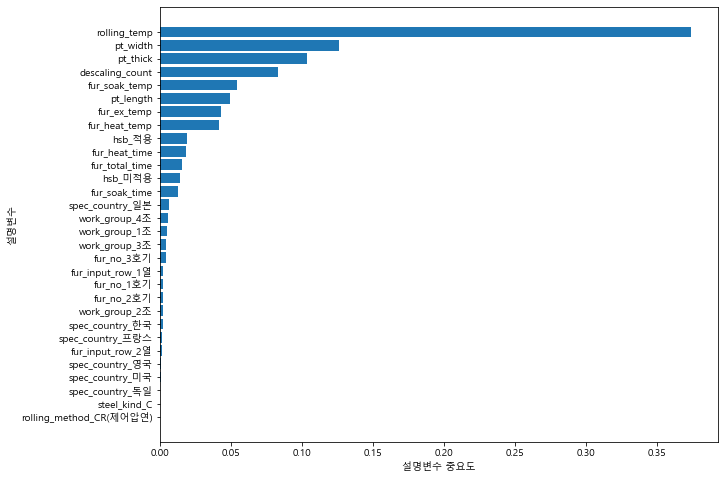

In [52]:
# 설명변수 중요도 그래프
plt.figure (figsize=(10, 8))

rf_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(rf_importance))
plt.barh(y = coordinates, width = rf_importance["Importance"])
plt.yticks(coordinates, rf_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### @@ RF.도출된 영향인자는 ...


## Gradient Boosting

In [53]:
gb_default = GradientBoostingClassifier(min_samples_leaf=v_min_samples_leaf)
gb_default.fit(df_train_x, df_train_y)

y_pred_train = gb_default.predict(df_train_x)
y_pred_test = gb_default.predict(df_test_x)

# 모델 성능 평가
print("Train 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_train_y, y_pred_train)),"\n")
print("Accuracy...  {:.3f}".format(gb_default.score(df_train_x, df_train_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_train_y, y_pred_train, digits=3))

print("Test 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_test_y, y_pred_test)),"\n")
print("Accuracy...  {:.3f}".format(gb_default.score(df_test_x, df_test_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_test_y, y_pred_test, digits=3))

Train 모델...
Confusion matrix... 
[[192   0]
 [  0 335]] 

Accuracy...  1.000 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     1.000     1.000       192
          양품      1.000     1.000     1.000       335

    accuracy                          1.000       527
   macro avg      1.000     1.000     1.000       527
weighted avg      1.000     1.000     1.000       527

Test 모델...
Confusion matrix... 
[[ 98   0]
 [  0 128]] 

Accuracy...  1.000 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     1.000     1.000        98
          양품      1.000     1.000     1.000       128

    accuracy                          1.000       226
   macro avg      1.000     1.000     1.000       226
weighted avg      1.000     1.000     1.000       226



### GB.변수 중요도...영향인자 선정

In [54]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
gb_importance = pd.DataFrame()
gb_importance["Feature"] = df_train_x.columns
gb_importance["Importance"] = gb_default.feature_importances_

# ds_feature_importance의 테이블을 중요도별로 정렬
gb_importance.sort_values("Importance", ascending=False, inplace = True)
gb_importance

,Feature,Importance
9,rolling_temp,5.719e-01
10,descaling_count,1.057e-01
5,fur_soak_temp,1.010e-01
18,hsb_미적용,8.521e-02
8,fur_ex_temp,6.348e-02
19,hsb_적용,4.571e-02
0,pt_thick,2.670e-02
3,fur_heat_temp,2.244e-04
2,pt_length,1.998e-05
4,fur_heat_time,9.792e-06


Text(0, 0.5, '설명변수')

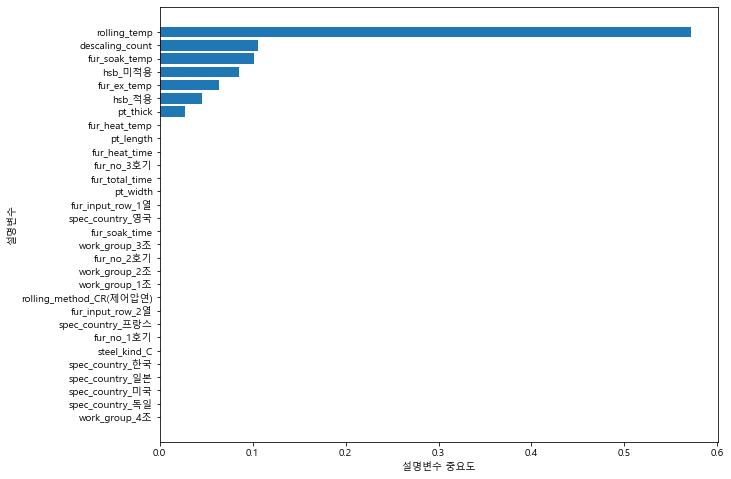

In [55]:
# 설명변수 중요도 그래프
plt.figure (figsize=(10, 8))

gb_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(gb_importance))
plt.barh(y = coordinates, width = gb_importance["Importance"])
plt.yticks(coordinates, gb_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### @@ GB.도출된 영향인자는 ...


### ...영향인자 선정(예시)

* EDA, 로지스틱 회귀, DT, RF, GB 결과를 종합하여 최종 영향인자 선정 및 기술적 해석
			
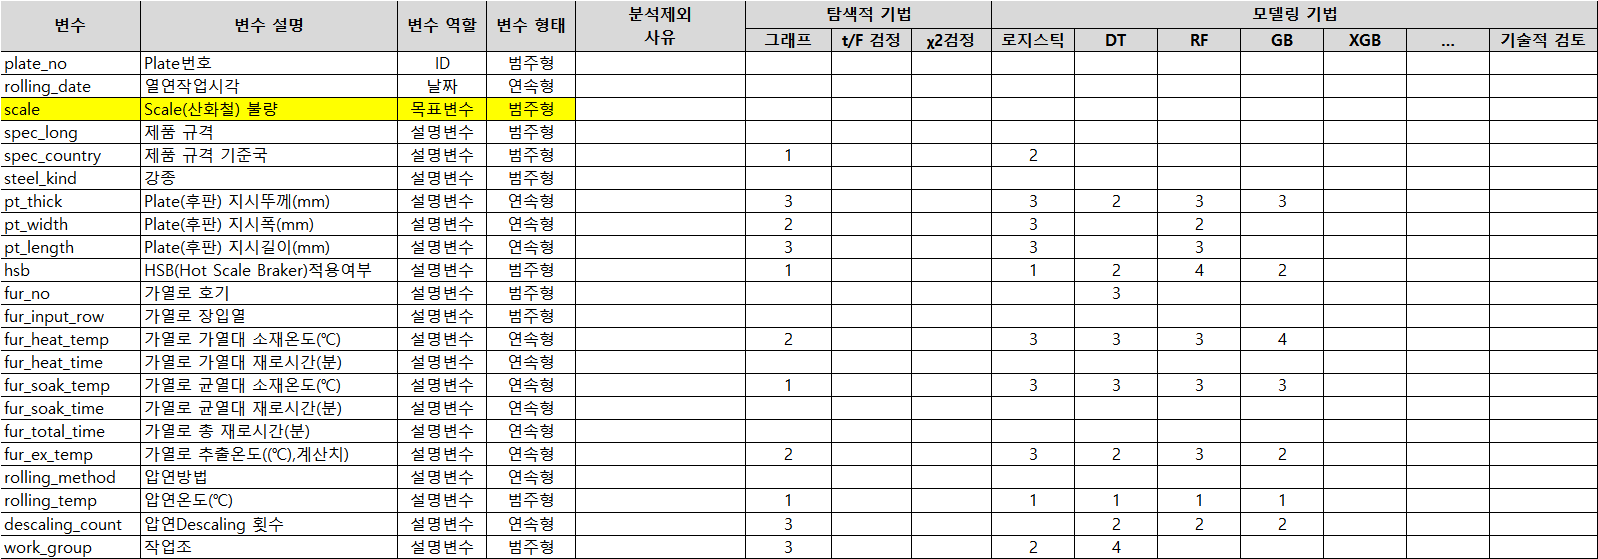
 

* 선정된 영향인자 
    - rolling_temp, descaling_count, fur_soak_temp, fur_ex_temp, fur_heat_temp
    - hsb는 미적용시 100% 불량 -> 혐의인자에 포함하거나 또는 "적용" 데이터 기준으로 혐의인자 제외하고 분석 가능

# 5.불량예측 모델링 및 개선안 도출

* 개선안 도출이 필요하므로 DT 모델 이용하여 hyper-para 최적화 

* hsb 적용 데이터 기준으로 최적조건 도출 및 불량 예측

In [56]:
# 불량~hsb 현황
fun_print_crosstab(df_anal, "hsb")

hsb    미적용   적용
scale          
불량      37  253
양품       0  463

hsb    미적용     적용
scale            
불량     1.0  0.353
양품     0.0  0.647


In [57]:
# hsb 적용 선택
df_anal9 = df_anal[df_anal['hsb']=='적용'] # 미적용(37) 제외, 적용(716)
df_anal9.reset_index(drop=True, inplace=True)

print(df_anal9.info(), '\n')
print('Scale불량... \n',df_anal9['hsb'].value_counts(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            716 non-null    object
 1   spec_country     716 non-null    object
 2   steel_kind       716 non-null    object
 3   pt_thick         716 non-null    int64 
 4   pt_width         716 non-null    int64 
 5   pt_length        716 non-null    int64 
 6   hsb              716 non-null    object
 7   fur_no           716 non-null    object
 8   fur_input_row    716 non-null    object
 9   fur_heat_temp    716 non-null    int64 
 10  fur_heat_time    716 non-null    int64 
 11  fur_soak_temp    716 non-null    int64 
 12  fur_soak_time    716 non-null    int64 
 13  fur_total_time   716 non-null    int64 
 14  fur_ex_temp      716 non-null    int64 
 15  rolling_method   716 non-null    object
 16  rolling_temp     716 non-null    int64 
 17  descaling_count  716 non-null    in

#### 목표/설명변수 구분

In [58]:
# 목표변수, 설명변수 구분
df_anal_y = df_anal9["scale"]
df_anal_x = df_anal9[["rolling_temp", "descaling_count", "fur_soak_temp", "fur_ex_temp", "fur_heat_temp"]]

display("목표변수(양품/불량)...", df_anal_y.head(3))
display("설명변수...", df_anal_x.head(3))

'목표변수(양품/불량)...'

0    양품
1    양품
2    양품
Name: scale, dtype: object

'설명변수...'

,rolling_temp,descaling_count,fur_soak_temp,fur_ex_temp,fur_heat_temp
0,934,8,1126,1126,1129
1,911,8,1132,1132,1140
2,935,10,1130,1130,1130


#### 범주형 설명변수 더미 변환

In [59]:
# 범주형 설명변수 더미 변환: 대상 없음
df_x_dummy = pd.get_dummies(df_anal_x)
print("Shape of dummy data:", df_x_dummy.shape)
df_x_dummy.head()

Shape of dummy data: (716, 5)


,rolling_temp,descaling_count,fur_soak_temp,fur_ex_temp,fur_heat_temp
0,934,8,1126,1126,1129
1,911,8,1132,1132,1140
2,935,10,1130,1130,1130
3,935,10,1130,1130,1130
4,915,10,1131,1131,1140


#### 데이터 분할

In [60]:
# 데이터 분할:train/test 
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, df_anal_y, test_size = 0.3)

print("Shape(Train): ", df_train.shape)
print("Shape(Test): ", df_test.shape)

display(df_train_y.head(3))  # 불량/양품 유지

Shape(Train):  (527, 19)
Shape(Test):  (226, 19)


257    양품
511    양품
539    양품
Name: scale, dtype: object

### @@ 공통 (leaf 자료 수만 지정한)기본 옵션 모델을 이용하여 변수 중요도 확인--> 영향인자 탐색
* Leaf 최소 자료수는 train 자료 수의 2% 수준 지정

In [61]:
v_min_samples_leaf = int(len(df_train_x)*0.02)
print("Leaf 최소 자료수는 ..",v_min_samples_leaf) 

Leaf 최소 자료수는 .. 10


## 의사결정나무

#### max_depth: 최대 깊이 변경에 따른 정확도 변화

In [62]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth

,Depth,TrainAccuracy,TestAccuracy
0,1,0.916,0.874
1,2,0.958,0.949
2,3,0.958,0.949
3,4,0.994,0.972
4,5,0.998,1.000
5,6,1.000,1.000
6,7,1.000,1.000
7,8,1.000,0.991
8,9,1.000,0.991
9,10,1.000,0.991


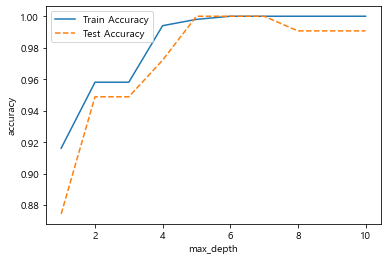

In [63]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

#### @@ max_depth = 6 

#### min_samples_leaf: 잎사귀 노드의 샘플 수 제한

In [64]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, max_depth=6)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.994,0.972
1,10,0.994,0.972
2,15,0.994,0.972
3,20,0.960,0.940
4,25,0.952,0.930
5,30,0.930,0.898
6,35,0.930,0.898
7,40,0.916,0.874
8,45,0.916,0.874
9,50,0.916,0.874


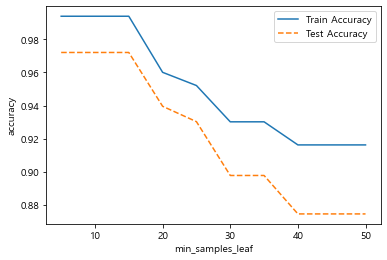

In [65]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_leaf"); plt.ylabel("accuracy")
plt.legend()

#### @@ min_samples_leaf = 10

#### min_samples_split: 분할하기 위한 노드의 최소 샘플 수

In [66]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split=v_min_samples_split, min_samples_leaf = 10, max_depth = 6)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.994,0.972
1,20,0.994,0.972
2,30,0.994,0.972
3,40,0.994,0.972
4,50,0.994,0.972
5,60,0.994,0.972
6,70,0.994,0.972
7,80,0.994,0.972
8,90,0.958,0.949
9,100,0.958,0.949


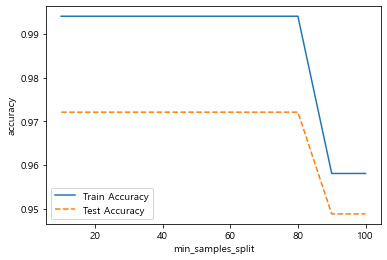

In [67]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_split"); plt.ylabel("accuracy")
plt.legend()

#### @@ 영향 없음

### 최종 모델

In [68]:
dt_final = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 10)
dt_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)

### 예측 & 평가

In [69]:
# 예측 
y_pred_train = dt_final.predict(df_train_x)
y_pred_test = dt_final.predict(df_test_x)

# 모델 성능 평가
print("Train 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_train_y, y_pred_train)),"\n")
print("Accuracy...  {:.3f}".format(dt_final.score(df_train_x, df_train_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_train_y, y_pred_train, digits=3))

print("Test 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_test_y, y_pred_test)),"\n")
print("Accuracy...  {:.3f}".format(dt_final.score(df_test_x, df_test_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_test_y, y_pred_test, digits=3))

Train 모델...
Confusion matrix... 
[[182   3]
 [  0 316]] 

Accuracy...  0.994 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     0.984     0.992       185
          양품      0.991     1.000     0.995       316

    accuracy                          0.994       501
   macro avg      0.995     0.992     0.994       501
weighted avg      0.994     0.994     0.994       501

Test 모델...
Confusion matrix... 
[[ 62   6]
 [  0 147]] 

Accuracy...  0.972 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      1.000     0.912     0.954        68
          양품      0.961     1.000     0.980       147

    accuracy                          0.972       215
   macro avg      0.980     0.956     0.967       215
weighted avg      0.973     0.972     0.972       215



### DT.변수 중요도...영향인자 선정

In [70]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
dt_importance = pd.DataFrame()
dt_importance["Feature"] = df_train_x.columns
dt_importance["Importance"] = dt_final.feature_importances_

# ds_feature_importance의 테이블을 중요도별로 정렬
dt_importance.sort_values("Importance", ascending=False, inplace = True)
dt_importance

,Feature,Importance
0,rolling_temp,0.698
3,fur_ex_temp,0.152
1,descaling_count,0.147
2,fur_soak_temp,0.002
4,fur_heat_temp,0.000


Text(0, 0.5, '설명변수')

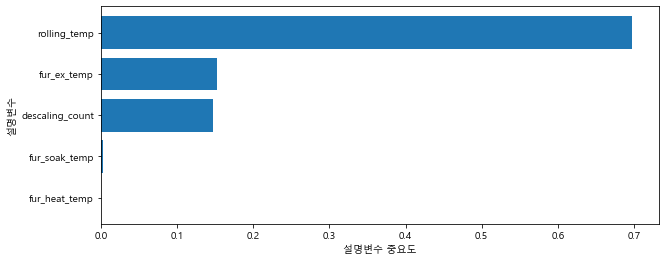

In [71]:
# 설명변수 중요도 그래프
plt.figure (figsize=(10, 4))

dt_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(dt_importance))
plt.barh(y = coordinates, width = dt_importance["Importance"])
plt.yticks(coordinates, dt_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### 최적조건, 개선안 도출

In [72]:
# 변수명 저장
v_feature_name = df_train_x.columns
v_feature_name

Index(['rolling_temp', 'descaling_count', 'fur_soak_temp', 'fur_ex_temp',
       'fur_heat_temp'],
      dtype='object')

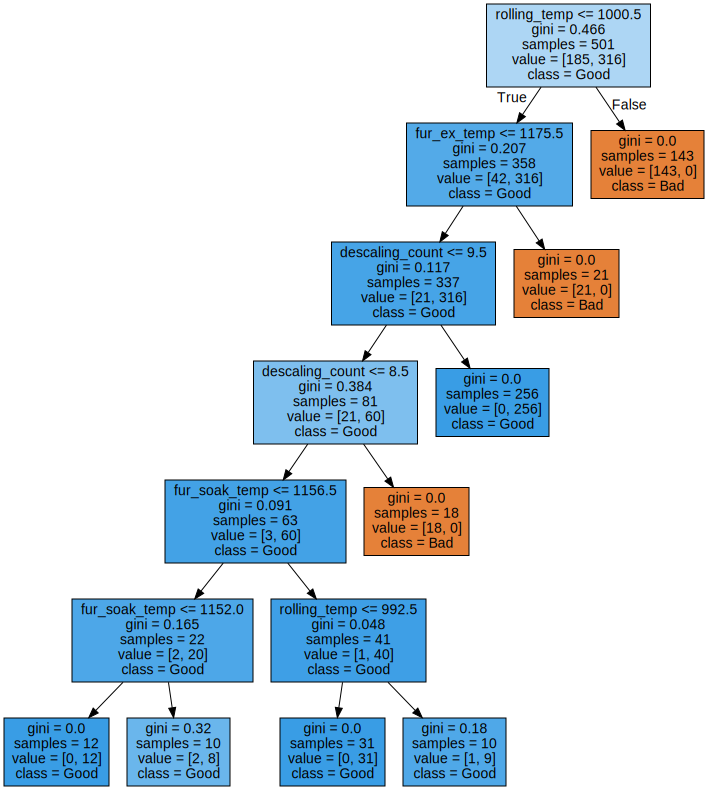

In [73]:
# 최종모델 상세 확인
export_graphviz(dt_final, out_file="tree_final.dot", 
                class_names = ["Bad", "Good"], # 목표변수 값이 숫자-> Label 직접 지정
                feature_names = v_feature_name, impurity = True, filled = True)

# graphviz를 이용해 트리 확인
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 영향인자 상세 분석

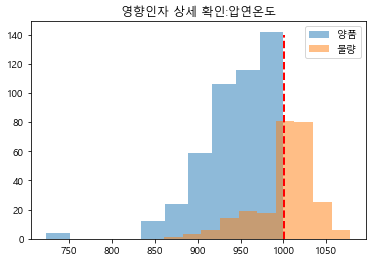

In [74]:
plt.title("영향인자 상세 확인:압연온도")
plt.hist(df_anal9[df_anal9["scale"] == "양품"]["rolling_temp"], label = "양품", alpha = 0.5)
plt.hist(df_anal9[df_anal9["scale"] == "불량"]["rolling_temp"], label = "불량", alpha = 0.5)
plt.vlines(1000.5, 0, 140, color='red', linestyle='--', linewidth=2)

plt.legend()
plt.show()

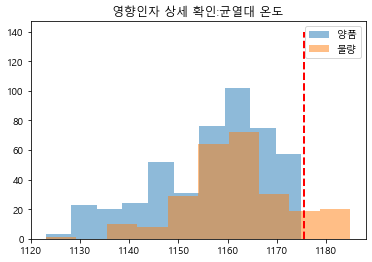

In [75]:
plt.title("영향인자 상세 확인:균열대 온도")
plt.hist(df_anal9[df_anal9["scale"] == "양품"]["fur_soak_temp"], label = "양품", alpha = 0.5)
plt.hist(df_anal9[df_anal9["scale"] == "불량"]["fur_soak_temp"], label = "불량", alpha = 0.5)
plt.vlines(1175.5, 0, 140, color='red', linestyle='--', linewidth=2)

plt.legend()
plt.show()

### 특정 영향인자 상세분석

In [76]:
# 데이터 분할:train/test 
df_train_xsel = df_train_x[["fur_soak_temp"]]
df_test_xsel = df_test_x[["fur_soak_temp"]]
# df_train_xsel = df_train_x[["rolling_temp"]]
# df_test_xsel = df_test_x[["rolling_temp"]]

# df_train_xsel = df_train_x[["fur_soak_temp", "rolling_temp"]]
# df_test_xsel = df_test_x[["fur_soak_temp", "rolling_temp"]]

print("Shape(Train): ", df_train_xsel.shape)
print("Shape(Test): ", df_test_xsel.shape)

Shape(Train):  (501, 1)
Shape(Test):  (215, 1)


In [77]:
dt_final = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 10)
dt_final.fit(df_train_xsel, df_train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)

### 예측 & 평가 ..여기서는 큰 의미는 없음 !!

In [78]:
# 예측 
y_pred_train = dt_final.predict(df_train_xsel)
y_pred_test = dt_final.predict(df_test_xsel)

# 모델 성능 평가
print("Train 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_train_y, y_pred_train)),"\n")
print("Accuracy...  {:.3f}".format(dt_final.score(df_train_xsel, df_train_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_train_y, y_pred_train, digits=3))

print("Test 모델...")
print("==========================")
print("Confusion matrix... \n{}".format(confusion_matrix(df_test_y, y_pred_test)),"\n")
print("Accuracy...  {:.3f}".format(dt_final.score(df_test_xsel, df_test_y)),"\n")
print("Precision-Recall-F1 Score... \n", classification_report(df_test_y, y_pred_test, digits=3))

Train 모델...
Confusion matrix... 
[[ 56 129]
 [ 24 292]] 

Accuracy...  0.695 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      0.700     0.303     0.423       185
          양품      0.694     0.924     0.792       316

    accuracy                          0.695       501
   macro avg      0.697     0.613     0.608       501
weighted avg      0.696     0.695     0.656       501

Test 모델...
Confusion matrix... 
[[ 27  41]
 [  9 138]] 

Accuracy...  0.767 

Precision-Recall-F1 Score... 
               precision    recall  f1-score   support

          불량      0.750     0.397     0.519        68
          양품      0.771     0.939     0.847       147

    accuracy                          0.767       215
   macro avg      0.760     0.668     0.683       215
weighted avg      0.764     0.767     0.743       215



### 최적조건, 개선안 도출

In [79]:
# 변수명 저장
v_feature_name = df_train_xsel.columns
v_feature_name

Index(['fur_soak_temp'], dtype='object')

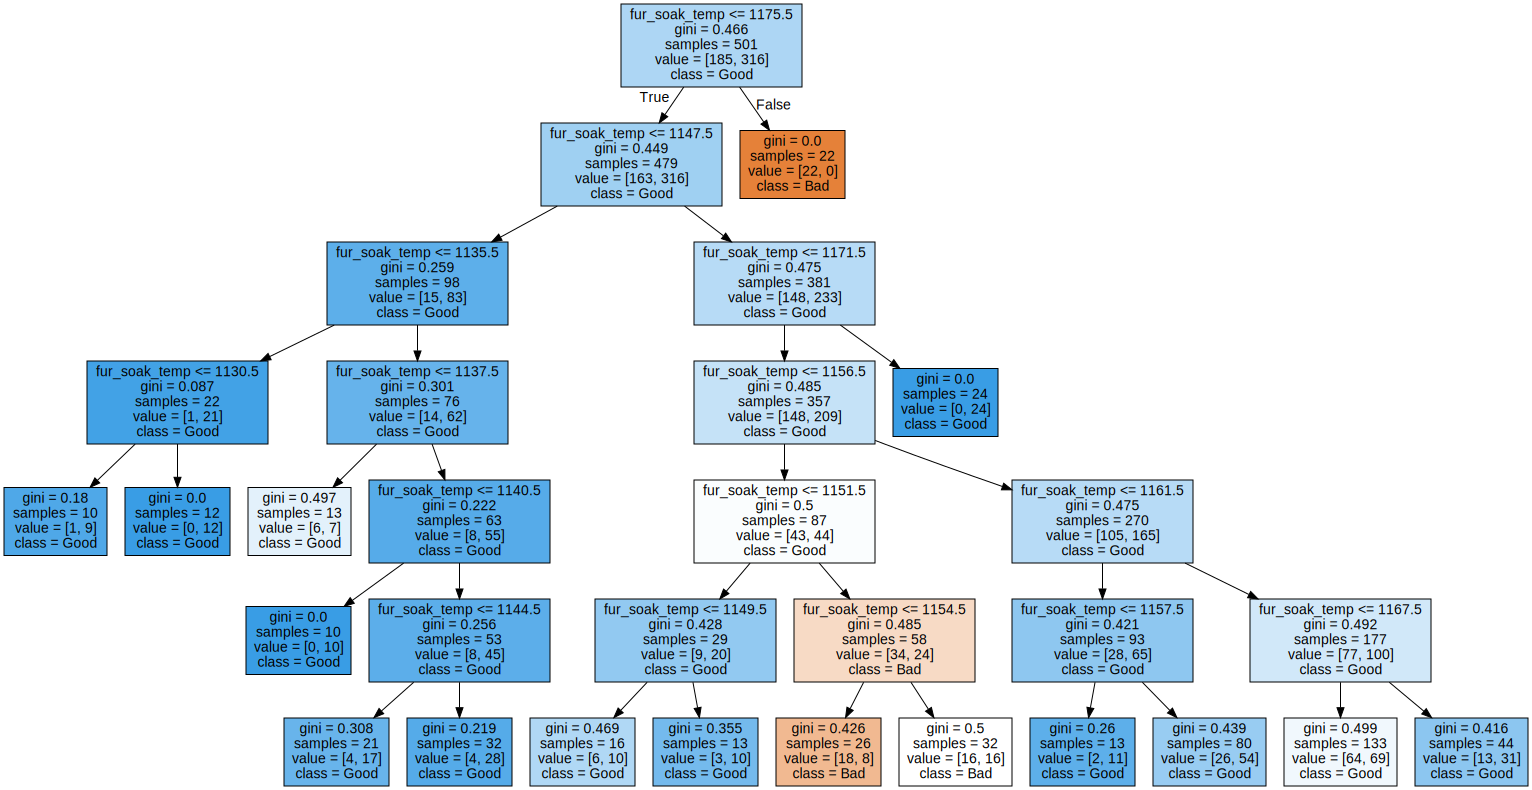

In [80]:
# 최종모델 상세 확인
export_graphviz(dt_final, out_file="tree_final_sel.dot", 
                class_names = ["Bad", "Good"], # 목표변수 값이 숫자-> Label 직접 지정
                feature_names = v_feature_name, impurity = True, filled = True)

# graphviz를 이용해 트리 확인
with open("tree_final_sel.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

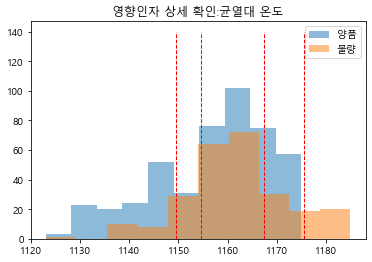

In [81]:
plt.title("영향인자 상세 확인:균열대 온도")
plt.hist(df_anal9[df_anal9["scale"] == "양품"]["fur_soak_temp"], label = "양품", alpha = 0.5)
plt.hist(df_anal9[df_anal9["scale"] == "불량"]["fur_soak_temp"], label = "불량", alpha = 0.5)
# plt.vlines(1175.5, 0, 140, color='red')
plt.vlines(1175.5, 0, 140, color='red', linestyle='--', linewidth=1)
plt.vlines(1167.5, 0, 140, color='red', linestyle='--', linewidth=1)
plt.vlines(1154.5, 0, 140, color='red', linestyle='--', linewidth=1)
plt.vlines(1149.5, 0, 140, color='red', linestyle='--', linewidth=1)

plt.legend()
plt.show()

In [82]:
# plt.title("영향인자 상세 확인:압연온도")
# plt.hist(df_anal9[df_anal9["scale"] == "양품"]["rolling_temp"], label = "양품", alpha = 0.5)
# plt.hist(df_anal9[df_anal9["scale"] == "불량"]["rolling_temp"], label = "불량", alpha = 0.5)

# plt.vlines(1000.5, 0, 140, color='red', linestyle='--', linewidth=1)
# plt.vlines(993.5, 0, 140, color='red', linestyle='--', linewidth=1)
# # plt.vlines(960.5, 0, 140, color='red', linestyle='--', linewidth=2)

# plt.legend()
# plt.show()

# End of 종합실습